In [36]:
from python_src.dump import dump
from python_src.xyz import xyz
from python_src.svg import svg
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
%matplotlib inline
import math
from multiprocessing.pool import ThreadPool
import os, time
import numpy as np
import glob
import pickle
from sklearn.utils import shuffle
import random
import re


def process_movie_data_with_velocity(file_path):
    #print("Proccess id: ", os.getpid())
    xyz_array=None
    key = file_path
    
    data = dump(file_path)
    data.map(1,"id")
    #t = data.time()
    #selecting last index from sorted time frames
    #time_value = t[-1]
    #time_index = data.findtime(time_value)
    #last_snap_shot = data.viz(time_index)
    #xyz_array = np.array(last_snap_shot[2])
    xyz_array = np.array([data.snaps[i].atoms[:,2:] for i in range(len(data.snaps))])
    # Return a tuple
    return (key, xyz_array)


def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
     
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

actual_data_list = sorted(glob.glob("data/actual*.lammpstrj"), key=alphanum_key)
print(actual_data_list)
preidiction_list = sorted(glob.glob("data/predicted*.lammpstrj"), key=alphanum_key)
print(preidiction_list)
md_dt_list = sorted(glob.glob("data_actual_dt/actual*.lammpstrj"), key=alphanum_key)
print(md_dt_list)

['data\\actual100x.lammpstrj', 'data\\actual400x.lammpstrj', 'data\\actual1000x.lammpstrj', 'data\\actual4000x.lammpstrj']
['data\\predicted100x.lammpstrj', 'data\\predicted400x.lammpstrj', 'data\\predicted1000x.lammpstrj', 'data\\predicted4000x.lammpstrj']
['data_actual_dt\\actual0.01x.lammpstrj', 'data_actual_dt\\actual0.04x.lammpstrj', 'data_actual_dt\\actual0.10x.lammpstrj']


In [39]:
def apply_periodic_boundries(vector):
    lx=3.39745*2
    ly=3.39745*2
    lz=3.39745*2
    # periodic boundary
    if (vector[0] > lx/2.0):
        vector[0] = vector[0] - lx
    if (vector[0] < -lx/2.0):
        vector[0] = vector[0] + lx
    if (vector[1] > ly/2.0):
        vector[1] = vector[1] - ly
    if (vector[1] < -ly/2.0):
        vector[1] = vector[1] + ly
    if (vector[2] > lz/2.0):
        vector[2] = vector[2] - lz
    if (vector[2] < -lz/2.0):
        vector[2] = vector[2] + lz
    return vector

def get_energies(base_results, dcut=2.5):
    energy_result = []
    time_size, particle_size, _=base_results.shape
    
    elj = 1.0
    dcut2 = dcut*dcut
    dcut6 = dcut2 * dcut2 * dcut2
    dcut12 = dcut6 * dcut6
    d = 1 #recall that we are working in reduced units where the unit of length is the diameter of the particle
    d2 = d * d
    d6 = d2 * d2 * d2
    d_cut_off = dcut2 * d2
        
    energy_shift = 4*elj*((1/dcut12) - (1/dcut6))
    
    
    for t in range(time_size):
        total_lj_atom_atom = 0.0
        total_pe = 0.0
        for i in range(particle_size):
            uljpair = 0.0
            for j in range(particle_size):
                if (j == i):
                    continue
                r_vec = base_results[t,i,0:3] - base_results[t,j,0:3]
                #Add periodic boundries
                r_vec= apply_periodic_boundries(r_vec)
                r2 = np.sum(np.square(r_vec))
                #Cut off check
                if (r2 < d_cut_off):
                    r6 = r2 * r2 * r2
                    uljpair +=  4 * elj * (d6 / r6) * ( ( d6 / r6 ) - 1 ) - energy_shift
                    
            total_lj_atom_atom += uljpair
            total_pe += 0.5 * 1.0 * (np.sum(base_results[t,i,3:6]**2))
            
        total_lj_atom_atom = 0.5*total_lj_atom_atom
        total_energy = (total_lj_atom_atom + total_pe)/particle_size
        energy_result.append(total_energy)
        #break
    return energy_result

(20001,)
(20001,)
(20001,)
(20001,)
(5001,)
(2001,)
(501,)


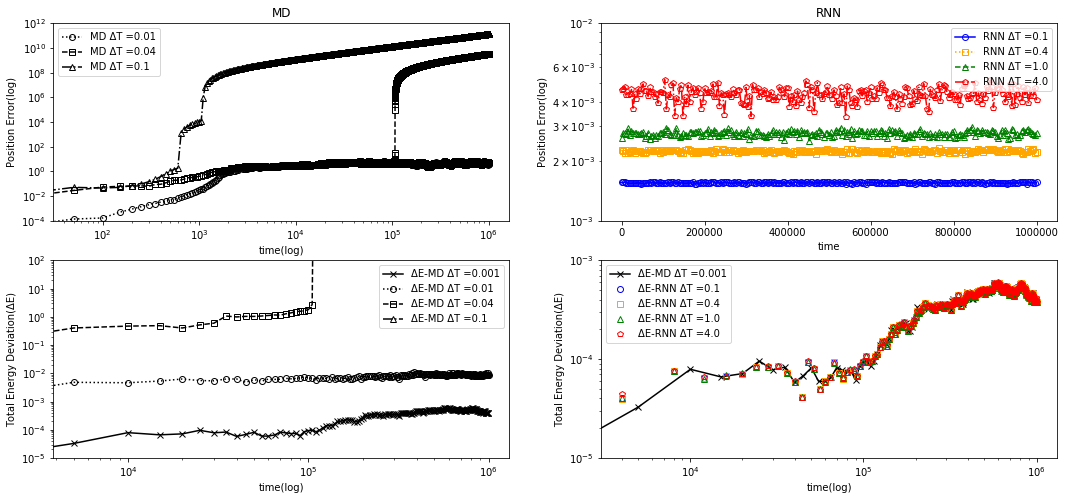

In [40]:
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))

#ax_insert = inset_axes(ax[0], height="100%", width="100%", loc='lower left', bbox_to_anchor=(0.4,0.05,0.55,0.55), bbox_transform=ax[0].transAxes)

#ax2_insert = inset_axes(ax[1], height="100%", width="100%", loc='lower left', bbox_to_anchor=(0.4,0.05,0.55,0.55), bbox_transform=ax[1].transAxes)


_, base_results = process_movie_data_with_velocity('data_actual_dt/base.lammpstrj')

how_freq_=1
base_dt_MD= 0.001
#detltaT = np.array([10, 20, 50, 100])
detltaT = np.array([10, 40, 100])


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

energy_factor=100
time_fac = 100/2

total_energy_base = np.array(get_energies(base_results[0:-1:energy_factor,:,:]))
total_energy_base = abs((total_energy_base-total_energy_base[0])/total_energy_base[0])

x_data_base = np.arange(0,total_energy_base.shape[0],1) *100*time_fac

ax[1,0].plot(x_data_base, total_energy_base, label='ΔE-MD ΔT ='+ str(0.001), 
                               color='black',linestyle='-', marker= 'x', markerfacecolor='none')


ax[1,1].plot(x_data_base, total_energy_base, label='ΔE-MD ΔT ='+ str(0.001), 
                               color='black',linestyle='-', marker= 'x', markerfacecolor='none')



for i, item in enumerate(md_dt_list):
    actual_data = base_results
    _ , predicted_data = process_movie_data_with_velocity(item)
    size__= min(predicted_data.shape[0], actual_data.shape[0])
    error_values =  np.square(predicted_data[0:size__,:,0:3]-actual_data[0:size__,:,0:3])
    error_values = np.sum(error_values, axis=2)#np.sqrt()
    average_error = np.sqrt(np.average(error_values, axis=1))
    #average_error = np.average(np.average(error_values, axis=2), axis=1)
    x_data = np.arange(0,average_error.shape[0],1) *base_dt_MD*1000*time_fac
    deltaT_ = detltaT[i]*base_dt_MD
    print(x_data.shape)
    
    lgnd_text=''
    #lgnd_text = ' , AVG(16, 3D) MSE =' + "{:.2e}".format(np.average(average_error**2)) 
    #lgnd_text = lgnd_text + ", Avg(100-10^6) Pos_Error^2="+ "{:E}".format(np.average(average_error[200:]**2))
 
    ax[0,0].plot(x_data[::how_freq_], average_error[::how_freq_], label='MD ΔT ='+ str(deltaT_) +lgnd_text, 
                       color='black',linestyle=linestyles[i+1], marker= markerstyles[i], markerfacecolor='none')   
    
    
    if i<3:
        total_energy_ = np.array(get_energies(predicted_data[:average_error.shape[0]:energy_factor,:,:]))
        total_energy_ = abs((total_energy_-total_energy_[0])/total_energy_[0])


        ax[1,0].plot(x_data[::energy_factor], total_energy_, label='ΔE-MD ΔT ='+ str(deltaT_) +lgnd_text, 
                                   color='black',linestyle=linestyles[i+1], marker= markerstyles[i], markerfacecolor='none')
    

    
    
#detltaT = np.array([100, 200, 400, 1000, 2000, 4000])
detltaT = np.array([100, 400, 1000, 4000])
how_freq_=1
#fig=plt.figure(figsize=(12, 10))
base_dt_MD= 0.001

for i, item in enumerate(actual_data_list):
    _ , actual_data = process_movie_data_with_velocity(item)
    _ , predicted_data = process_movie_data_with_velocity(preidiction_list[i])
    error_values =  np.square(predicted_data[:,:,0:3]-actual_data[:,:,0:3])
    error_values = np.sum(error_values, axis=2)#np.sqrt()
    average_error = np.sqrt(np.average(error_values, axis=1))
    x_data = np.arange(0,average_error.shape[0],1) *detltaT[i]*base_dt_MD*10*time_fac
    deltaT_ = detltaT[i]*base_dt_MD
    print(x_data.shape)
    how_freq_=8000//detltaT[i]
    
    lgnd_text=''
    #lgnd_text = ' , AVG(16, 3D) MSE =' + "{:.2e}".format(np.average(average_error**2)) 
    #lgnd_text = lgnd_text + ", Avg(100-10^6) Pos_Error^2="+ "{:E}".format(np.average(average_error[200:]**2))
    ax[0,1].plot(x_data[::how_freq_], average_error[::how_freq_], label='RNN ΔT ='+ str(deltaT_) +lgnd_text, 
               linestyle=linestyles[i], color=colors[i], marker= markerstyles[i], markerfacecolor='none')  
    
    
    
    total_energy_ = np.array(get_energies(predicted_data[:average_error.shape[0]:how_freq_,:,:]))
    total_energy_ = abs((total_energy_-total_energy_[0])/total_energy_[0])


    ax[1,1].plot(x_data[::how_freq_], total_energy_, label='ΔE-RNN ΔT ='+ str(deltaT_) +lgnd_text, 
                           color=colors[i],linestyle='none', marker= markerstyles[i], markerfacecolor='none')

    
ax[0,0].set_yscale('log')
ax[0,0].set_title("MD")
ax[0,0].legend(loc='upper left')
ax[0,0].set_xlabel('time(log)')
ax[0,0].set_ylabel('Position Error(log)')
ax[0,0].set_xscale('log')
ax[0,0].set_ylim(10**-4, 10**12)


ax[1,0].set_yscale('log')
ax[1,0].legend(loc='best')
ax[1,0].set_xlabel('time(log)')
ax[1,0].set_ylabel('Total Energy Deviation(ΔE)')
ax[1,0].set_xscale('log')
ax[1,0].set_ylim(1*(10**-5), 1*(10**2))     



ax[0,1].set_yscale('log')
ax[0,1].set_title("RNN")
ax[0,1].legend(loc='upper right')
ax[0,1].set_xlabel('time')
ax[0,1].set_ylabel('Position Error(log)')
ax[0,1].set_ylim(1*(10**-3), 1*(10**-2))


ax[1,1].set_yscale('log')
ax[1,1].legend(loc='best')
ax[1,1].set_xlabel('time(log)')
ax[1,1].set_ylabel('Total Energy Deviation(ΔE)')
ax[1,1].set_xscale('log')
ax[1,1].set_ylim(1*(10**-5), 1*(10**-3))     

plt.show()

(20001,)
(20001,)
(20001,)
(20001,)
(5001,)
(2001,)
(501,)


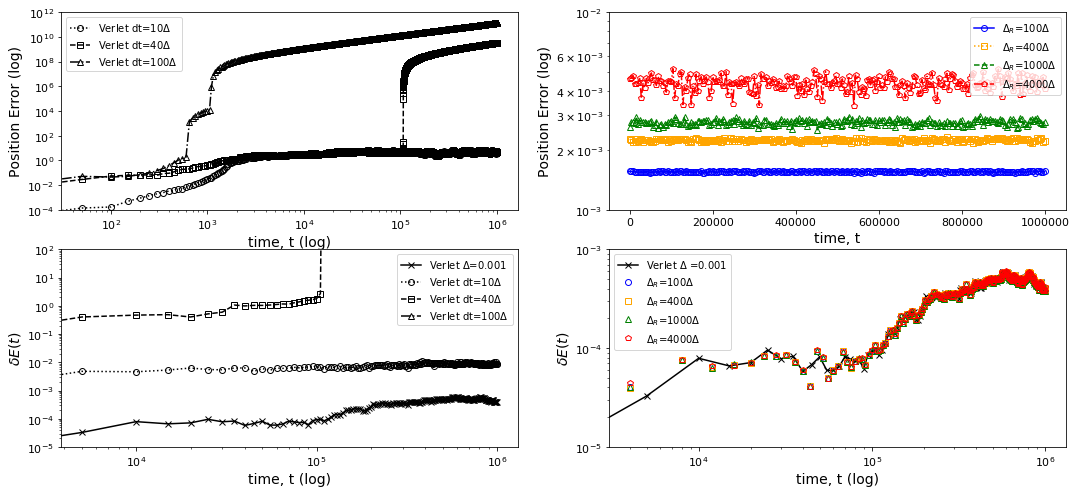

In [54]:
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))

#ax_insert = inset_axes(ax[0], height="100%", width="100%", loc='lower left', bbox_to_anchor=(0.4,0.05,0.55,0.55), bbox_transform=ax[0].transAxes)

#ax2_insert = inset_axes(ax[1], height="100%", width="100%", loc='lower left', bbox_to_anchor=(0.4,0.05,0.55,0.55), bbox_transform=ax[1].transAxes)


_, base_results = process_movie_data_with_velocity('data_actual_dt/base.lammpstrj')

how_freq_=1
base_dt_MD= 0.001
#detltaT = np.array([10, 20, 50, 100])
detltaT = np.array([10, 40, 100])


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

energy_factor=100
time_fac = 100/2

total_energy_base = np.array(get_energies(base_results[0:-1:energy_factor,:,:]))
total_energy_base = abs((total_energy_base-total_energy_base[0])/total_energy_base[0])

x_data_base = np.arange(0,total_energy_base.shape[0],1) *100*time_fac

ax[1,0].plot(x_data_base, total_energy_base, label='Verlet $\Delta$='+ str(0.001), 
                               color='black',linestyle='-', marker= 'x', markerfacecolor='none')


ax[1,1].plot(x_data_base, total_energy_base, label='Verlet $\Delta$ ='+ str(0.001), 
                               color='black',linestyle='-', marker= 'x', markerfacecolor='none')

for i, item in enumerate(md_dt_list):
    actual_data = base_results
    _ , predicted_data = process_movie_data_with_velocity(item)
    size__= min(predicted_data.shape[0], actual_data.shape[0])
    error_values =  np.square(predicted_data[0:size__,:,0:3]-actual_data[0:size__,:,0:3])
    error_values = np.sum(error_values, axis=2)#np.sqrt()
    average_error = np.sqrt(np.average(error_values, axis=1))
    #average_error = np.average(np.average(error_values, axis=2), axis=1)
    x_data = np.arange(0,average_error.shape[0],1) *base_dt_MD*1000*time_fac
    deltaT_ = detltaT[i]*base_dt_MD
    print(x_data.shape)
    
    lgnd_text='$\Delta$'
    #lgnd_text = ' , AVG(16, 3D) MSE =' + "{:.2e}".format(np.average(average_error**2)) 
    #lgnd_text = lgnd_text + ", Avg(100-10^6) Pos_Error^2="+ "{:E}".format(np.average(average_error[200:]**2))
 
    ax[0,0].plot(x_data[::how_freq_], average_error[::how_freq_], label='Verlet dt='+ str(int(deltaT_/0.001)) +lgnd_text, 
                       color='black',linestyle=linestyles[i+1], marker= markerstyles[i], markerfacecolor='none')   
    
    
    if i<3:
        total_energy_ = np.array(get_energies(predicted_data[:average_error.shape[0]:energy_factor,:,:]))
        total_energy_ = abs((total_energy_-total_energy_[0])/total_energy_[0])


        ax[1,0].plot(x_data[::energy_factor], total_energy_, label='Verlet dt='+ str(int(deltaT_/0.001)) +lgnd_text, 
                                   color='black',linestyle=linestyles[i+1], marker= markerstyles[i], markerfacecolor='none')
    

  
#detltaT = np.array([100, 200, 400, 1000, 2000, 4000])
detltaT = np.array([100, 400, 1000, 4000])
how_freq_=1
#fig=plt.figure(figsize=(12, 10))
base_dt_MD= 0.001

for i, item in enumerate(actual_data_list):
    _ , actual_data = process_movie_data_with_velocity(item)
    _ , predicted_data = process_movie_data_with_velocity(preidiction_list[i])
    error_values =  np.square(predicted_data[:,:,0:3]-actual_data[:,:,0:3])
    error_values = np.sum(error_values, axis=2)#np.sqrt()
    average_error = np.sqrt(np.average(error_values, axis=1))
    x_data = np.arange(0,average_error.shape[0],1) *detltaT[i]*base_dt_MD*10*time_fac
    deltaT_ = detltaT[i]*base_dt_MD
    print(x_data.shape)
    how_freq_=8000//detltaT[i]
    
    lgnd_text='$\Delta$'
    #lgnd_text = ' , AVG(16, 3D) MSE =' + "{:.2e}".format(np.average(average_error**2)) 
    #lgnd_text = lgnd_text + ", Avg(100-10^6) Pos_Error^2="+ "{:E}".format(np.average(average_error[200:]**2))
    ax[0,1].plot(x_data[::how_freq_], average_error[::how_freq_], label='$\Delta_R$='+ str(int(deltaT_/0.001)) +lgnd_text, 
               linestyle=linestyles[i], color=colors[i], marker= markerstyles[i], markerfacecolor='none')  
    
    
    
    total_energy_ = np.array(get_energies(predicted_data[:average_error.shape[0]:how_freq_,:,:]))
    total_energy_ = abs((total_energy_-total_energy_[0])/total_energy_[0])


    ax[1,1].plot(x_data[::how_freq_], total_energy_, label='$\Delta_R$='+ str(int(deltaT_/0.001)) +lgnd_text, 
                           color=colors[i],linestyle='none', marker= markerstyles[i], markerfacecolor='none')

    
ax[0,0].set_yscale('log')
#ax[0,0].set_title("MD")
ax[0,0].legend(loc='upper left')
ax[0,0].set_xlabel('time, t (log)', fontsize=14)
ax[0,0].set_ylabel('Position Error (log)', fontsize=14)
ax[0,0].set_xscale('log')
ax[0,0].set_ylim(10**-4, 10**12)
ax[0,0].tick_params(axis='both', which='major', labelsize=11)
ax[0,0].tick_params(axis='both', which='minor', labelsize=11)


ax[1,0].set_yscale('log')
ax[1,0].legend(loc='best')
ax[1,0].set_xlabel('time, t (log)', fontsize=14)
ax[1,0].set_ylabel('$\delta E(t)$', fontsize=14)
ax[1,0].set_xscale('log')
ax[1,0].set_ylim(1*(10**-5), 1*(10**2))
ax[1,0].tick_params(axis='both', which='major', labelsize=11)
ax[1,0].tick_params(axis='both', which='minor', labelsize=11)



ax[0,1].set_yscale('log')
#ax[0,1].set_title("RNN")
ax[0,1].legend(loc='upper right')
ax[0,1].set_xlabel('time, t', fontsize=14)
ax[0,1].set_ylabel('Position Error (log)', fontsize=14)
ax[0,1].set_ylim(1*(10**-3), 1*(10**-2))
ax[0,1].tick_params(axis='both', which='major', labelsize=11)
ax[0,1].tick_params(axis='both', which='minor', labelsize=11)


ax[1,1].set_yscale('log')
ax[1,1].legend(loc='best')
ax[1,1].set_xlabel('time, t (log)', fontsize=14)
ax[1,1].set_ylabel('$\delta E(t)$', fontsize=14)
ax[1,1].set_xscale('log')
ax[1,1].set_ylim(1*(10**-5), 1*(10**-3)) 
ax[1,1].tick_params(axis='both', which='major', labelsize=11)
ax[1,1].tick_params(axis='both', which='minor', labelsize=11)

plt.show()

(20001,)
(20001,)
(20001,)
(20001,)
(5001,)
(2001,)
(501,)


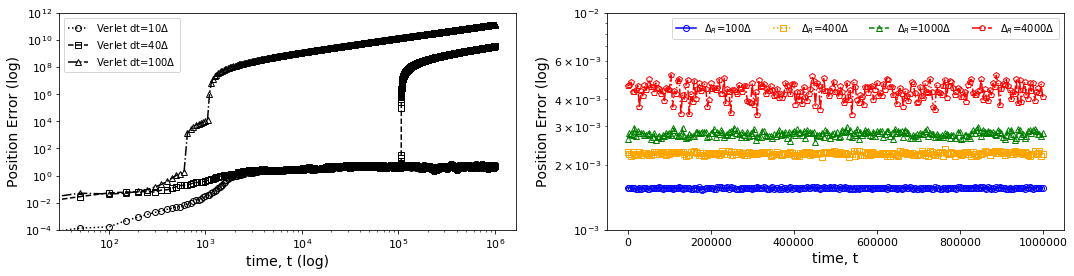

In [105]:
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

#ax_insert = inset_axes(ax[0], height="100%", width="100%", loc='lower left', bbox_to_anchor=(0.4,0.05,0.55,0.55), bbox_transform=ax[0].transAxes)

#ax2_insert = inset_axes(ax[1], height="100%", width="100%", loc='lower left', bbox_to_anchor=(0.4,0.05,0.55,0.55), bbox_transform=ax[1].transAxes)


_, base_results = process_movie_data_with_velocity('data_actual_dt/base.lammpstrj')

how_freq_=1
base_dt_MD= 0.001
#detltaT = np.array([10, 20, 50, 100])
detltaT = np.array([10, 40, 100])


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

energy_factor=100
time_fac = 100/2

total_energy_base = np.array(get_energies(base_results[0:-1:energy_factor,:,:]))
total_energy_base = abs((total_energy_base-total_energy_base[0])/total_energy_base[0])

x_data_base = np.arange(0,total_energy_base.shape[0],1) *100*time_fac

#ax[1,0].plot(x_data_base, total_energy_base, label='Verlet $\Delta$='+ str(0.001), 
#                               color='black',linestyle='-', marker= 'x', markerfacecolor='none')


#ax[1,1].plot(x_data_base, total_energy_base, label='Verlet $\Delta$ ='+ str(0.001), 
#                               color='black',linestyle='-', marker= 'x', markerfacecolor='none')

for i, item in enumerate(md_dt_list):
    actual_data = base_results
    _ , predicted_data = process_movie_data_with_velocity(item)
    size__= min(predicted_data.shape[0], actual_data.shape[0])
    error_values =  np.square(predicted_data[0:size__,:,0:3]-actual_data[0:size__,:,0:3])
    error_values = np.sum(error_values, axis=2)#np.sqrt()
    average_error = np.sqrt(np.average(error_values, axis=1))
    #average_error = np.average(np.average(error_values, axis=2), axis=1)
    x_data = np.arange(0,average_error.shape[0],1) *base_dt_MD*1000*time_fac
    deltaT_ = detltaT[i]*base_dt_MD
    print(x_data.shape)
    
    lgnd_text='$\Delta$'
    #lgnd_text = ' , AVG(16, 3D) MSE =' + "{:.2e}".format(np.average(average_error**2)) 
    #lgnd_text = lgnd_text + ", Avg(100-10^6) Pos_Error^2="+ "{:E}".format(np.average(average_error[200:]**2))
 
    ax[0].plot(x_data[::how_freq_], average_error[::how_freq_], label='Verlet dt='+ str(int(deltaT_/0.001)) +lgnd_text, 
                       color='black',linestyle=linestyles[i+1], marker= markerstyles[i], markerfacecolor='none')   
    
    
    #if i<3:
        #total_energy_ = np.array(get_energies(predicted_data[:average_error.shape[0]:energy_factor,:,:]))
        #total_energy_ = abs((total_energy_-total_energy_[0])/total_energy_[0])


        #ax[1,0].plot(x_data[::energy_factor], total_energy_, label='Verlet dt='+ str(int(deltaT_/0.001)) +lgnd_text, 
        #                           color='black',linestyle=linestyles[i+1], marker= markerstyles[i], markerfacecolor='none')
    

  
#detltaT = np.array([100, 200, 400, 1000, 2000, 4000])
detltaT = np.array([100, 400, 1000, 4000])
how_freq_=1
#fig=plt.figure(figsize=(12, 10))
base_dt_MD= 0.001

for i, item in enumerate(actual_data_list):
    _ , actual_data = process_movie_data_with_velocity(item)
    _ , predicted_data = process_movie_data_with_velocity(preidiction_list[i])
    error_values =  np.square(predicted_data[:,:,0:3]-actual_data[:,:,0:3])
    error_values = np.sum(error_values, axis=2)#np.sqrt()
    average_error = np.sqrt(np.average(error_values, axis=1))
    x_data = np.arange(0,average_error.shape[0],1) *detltaT[i]*base_dt_MD*10*time_fac
    deltaT_ = detltaT[i]*base_dt_MD
    print(x_data.shape)
    how_freq_=8000//detltaT[i]
    
    lgnd_text='$\Delta$'
    #lgnd_text = ' , AVG(16, 3D) MSE =' + "{:.2e}".format(np.average(average_error**2)) 
    #lgnd_text = lgnd_text + ", Avg(100-10^6) Pos_Error^2="+ "{:E}".format(np.average(average_error[200:]**2))
    ax[1].plot(x_data[::how_freq_], average_error[::how_freq_], label='$\Delta_R$='+ str(int(deltaT_/0.001)) +lgnd_text, 
               linestyle=linestyles[i], color=colors[i], marker= markerstyles[i], markerfacecolor='none')  
    
    #total_energy_ = np.array(get_energies(predicted_data[:average_error.shape[0]:how_freq_,:,:]))
    #total_energy_ = abs((total_energy_-total_energy_[0])/total_energy_[0])


    #ax[1,1].plot(x_data[::how_freq_], total_energy_, label='$\Delta_R$='+ str(int(deltaT_/0.001)) +lgnd_text, 
    #                       color=colors[i],linestyle='none', marker= markerstyles[i], markerfacecolor='none')

    
ax[0].set_yscale('log')
#ax[0,0].set_title("MD")
ax[0].legend(loc='upper left')
ax[0].set_xlabel('time, t (log)', fontsize=14)
ax[0].set_ylabel('Position Error (log)', fontsize=14)
ax[0].set_xscale('log')
ax[0].set_ylim(10**-4, 10**12)
ax[0].tick_params(axis='both', which='major', labelsize=11)
ax[0].tick_params(axis='both', which='minor', labelsize=11)

ax[1].set_yscale('log')
#ax[1].set_title("RNN")
ax[1].legend(loc='upper right', ncol=4)
ax[1].set_xlabel('time, t', fontsize=14)
ax[1].set_ylabel('Position Error (log)', fontsize=14)
ax[1].set_ylim(1*(10**-3), 1*(10**-2))
ax[1].tick_params(axis='both', which='major', labelsize=11)
ax[1].tick_params(axis='both', which='minor', labelsize=11)

plt.show()

(20001,)
(20001,)
(20001,)
(20001,)
(5001,)
(2001,)
(501,)


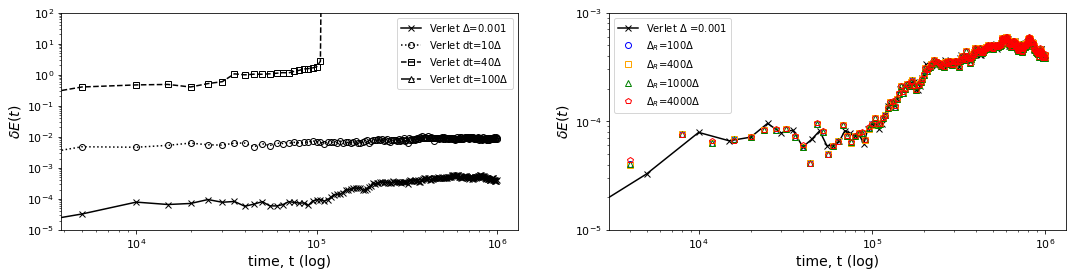

In [57]:
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

#ax_insert = inset_axes(ax[0], height="100%", width="100%", loc='lower left', bbox_to_anchor=(0.4,0.05,0.55,0.55), bbox_transform=ax[0].transAxes)

#ax2_insert = inset_axes(ax[1], height="100%", width="100%", loc='lower left', bbox_to_anchor=(0.4,0.05,0.55,0.55), bbox_transform=ax[1].transAxes)


_, base_results = process_movie_data_with_velocity('data_actual_dt/base.lammpstrj')

how_freq_=1
base_dt_MD= 0.001
#detltaT = np.array([10, 20, 50, 100])
detltaT = np.array([10, 40, 100])


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

energy_factor=100
time_fac = 100/2

total_energy_base = np.array(get_energies(base_results[0:-1:energy_factor,:,:]))
total_energy_base = abs((total_energy_base-total_energy_base[0])/total_energy_base[0])

x_data_base = np.arange(0,total_energy_base.shape[0],1) *100*time_fac

ax[0].plot(x_data_base, total_energy_base, label='Verlet $\Delta$='+ str(0.001), 
                               color='black',linestyle='-', marker= 'x', markerfacecolor='none')


ax[1].plot(x_data_base, total_energy_base, label='Verlet $\Delta$ ='+ str(0.001), 
                               color='black',linestyle='-', marker= 'x', markerfacecolor='none')

for i, item in enumerate(md_dt_list):
    actual_data = base_results
    _ , predicted_data = process_movie_data_with_velocity(item)
    size__= min(predicted_data.shape[0], actual_data.shape[0])
    error_values =  np.square(predicted_data[0:size__,:,0:3]-actual_data[0:size__,:,0:3])
    error_values = np.sum(error_values, axis=2)#np.sqrt()
    average_error = np.sqrt(np.average(error_values, axis=1))
    #average_error = np.average(np.average(error_values, axis=2), axis=1)
    x_data = np.arange(0,average_error.shape[0],1) *base_dt_MD*1000*time_fac
    deltaT_ = detltaT[i]*base_dt_MD
    print(x_data.shape)
    
    lgnd_text='$\Delta$'
    #lgnd_text = ' , AVG(16, 3D) MSE =' + "{:.2e}".format(np.average(average_error**2)) 
    #lgnd_text = lgnd_text + ", Avg(100-10^6) Pos_Error^2="+ "{:E}".format(np.average(average_error[200:]**2))
 
    #ax[0,0].plot(x_data[::how_freq_], average_error[::how_freq_], label='Verlet dt='+ str(int(deltaT_/0.001)) +lgnd_text, 
    #                   color='black',linestyle=linestyles[i+1], marker= markerstyles[i], markerfacecolor='none')   
    
    if i<3:
        total_energy_ = np.array(get_energies(predicted_data[:average_error.shape[0]:energy_factor,:,:]))
        total_energy_ = abs((total_energy_-total_energy_[0])/total_energy_[0])


        ax[0].plot(x_data[::energy_factor], total_energy_, label='Verlet dt='+ str(int(deltaT_/0.001)) +lgnd_text, 
                                   color='black',linestyle=linestyles[i+1], marker= markerstyles[i], markerfacecolor='none')
    
    
#detltaT = np.array([100, 200, 400, 1000, 2000, 4000])
detltaT = np.array([100, 400, 1000, 4000])
how_freq_=1
#fig=plt.figure(figsize=(12, 10))
base_dt_MD= 0.001

for i, item in enumerate(actual_data_list):
    _ , actual_data = process_movie_data_with_velocity(item)
    _ , predicted_data = process_movie_data_with_velocity(preidiction_list[i])
    error_values =  np.square(predicted_data[:,:,0:3]-actual_data[:,:,0:3])
    error_values = np.sum(error_values, axis=2)#np.sqrt()
    average_error = np.sqrt(np.average(error_values, axis=1))
    x_data = np.arange(0,average_error.shape[0],1) *detltaT[i]*base_dt_MD*10*time_fac
    deltaT_ = detltaT[i]*base_dt_MD
    print(x_data.shape)
    how_freq_=8000//detltaT[i]
    
    lgnd_text='$\Delta$'
    #lgnd_text = ' , AVG(16, 3D) MSE =' + "{:.2e}".format(np.average(average_error**2)) 
    #lgnd_text = lgnd_text + ", Avg(100-10^6) Pos_Error^2="+ "{:E}".format(np.average(average_error[200:]**2))
    #ax[0,1].plot(x_data[::how_freq_], average_error[::how_freq_], label='$\Delta_R$='+ str(int(deltaT_/0.001)) +lgnd_text, 
    #           linestyle=linestyles[i], color=colors[i], marker= markerstyles[i], markerfacecolor='none')  
    
    total_energy_ = np.array(get_energies(predicted_data[:average_error.shape[0]:how_freq_,:,:]))
    total_energy_ = abs((total_energy_-total_energy_[0])/total_energy_[0])


    ax[1].plot(x_data[::how_freq_], total_energy_, label='$\Delta_R$='+ str(int(deltaT_/0.001)) +lgnd_text, 
                           color=colors[i],linestyle='none', marker= markerstyles[i], markerfacecolor='none')

    

ax[0].set_yscale('log')
ax[0].legend(loc='best')
ax[0].set_xlabel('time, t (log)', fontsize=14)
ax[0].set_ylabel('$\delta E(t)$', fontsize=14)
ax[0].set_xscale('log')
ax[0].set_ylim(1*(10**-5), 1*(10**2))
ax[0].tick_params(axis='both', which='major', labelsize=11)
ax[0].tick_params(axis='both', which='minor', labelsize=11)

ax[1].set_yscale('log')
ax[1].legend(loc='best')
ax[1].set_xlabel('time, t (log)', fontsize=14)
ax[1].set_ylabel('$\delta E(t)$', fontsize=14)
ax[1].set_xscale('log')
ax[1].set_ylim(1*(10**-5), 1*(10**-3)) 
ax[1].tick_params(axis='both', which='major', labelsize=11)
ax[1].tick_params(axis='both', which='minor', labelsize=11)

plt.show()

(20001,)
(20001,)
(20001,)
(20001,)
(5001,)
(2001,)
(501,)


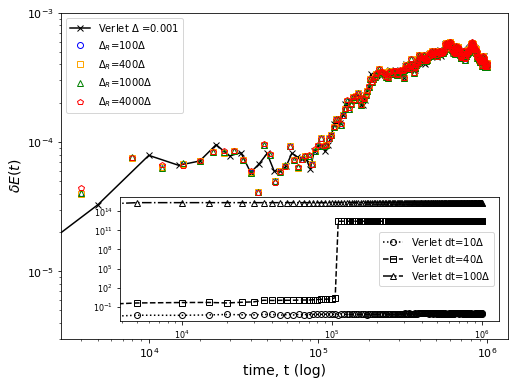

In [104]:
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
%matplotlib inline
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#fig, ax1 = plt.subplots()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

right_plot = inset_axes(ax, height="100%", width="100%", loc='lower left', bbox_to_anchor=(0.12,0.04,0.85,0.38), bbox_transform=ax.transAxes)

_, base_results = process_movie_data_with_velocity('data_actual_dt/base.lammpstrj')

how_freq_=1
base_dt_MD= 0.001
#detltaT = np.array([10, 20, 50, 100])
detltaT = np.array([10, 40, 100])


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

energy_factor=100
time_fac = 100/2

total_energy_base = np.array(get_energies(base_results[0:-1:energy_factor,:,:]))
total_energy_base = abs((total_energy_base-total_energy_base[0])/total_energy_base[0])

x_data_base = np.arange(0,total_energy_base.shape[0],1) *100*time_fac

#right_plot.plot(x_data_base, total_energy_base, label='Verlet $\Delta$='+ str(0.001), 
#                               color='black',linestyle='-', marker= 'x', markerfacecolor='none')


ax.plot(x_data_base, total_energy_base, label='Verlet $\Delta$ ='+ str(0.001), 
                               color='black',linestyle='-', marker= 'x', markerfacecolor='none')

for i, item in enumerate(md_dt_list):
    actual_data = base_results
    _ , predicted_data = process_movie_data_with_velocity(item)
    size__= min(predicted_data.shape[0], actual_data.shape[0])
    error_values =  np.square(predicted_data[0:size__,:,0:3]-actual_data[0:size__,:,0:3])
    error_values = np.sum(error_values, axis=2)#np.sqrt()
    average_error = np.sqrt(np.average(error_values, axis=1))
    #average_error = np.average(np.average(error_values, axis=2), axis=1)
    x_data = np.arange(0,average_error.shape[0],1) *base_dt_MD*1000*time_fac
    deltaT_ = detltaT[i]*base_dt_MD
    print(x_data.shape)
    
    lgnd_text='$\Delta$'
    #lgnd_text = ' , AVG(16, 3D) MSE =' + "{:.2e}".format(np.average(average_error**2)) 
    #lgnd_text = lgnd_text + ", Avg(100-10^6) Pos_Error^2="+ "{:E}".format(np.average(average_error[200:]**2))
 
    #ax[0,0].plot(x_data[::how_freq_], average_error[::how_freq_], label='Verlet dt='+ str(int(deltaT_/0.001)) +lgnd_text, 
    #                   color='black',linestyle=linestyles[i+1], marker= markerstyles[i], markerfacecolor='none')   
    
    if i<3:
        total_energy_ = np.array(get_energies(predicted_data[:average_error.shape[0]:energy_factor,:,:]))
        total_energy_ = abs((total_energy_-total_energy_[0])/total_energy_[0])


        right_plot.plot(x_data[::energy_factor], total_energy_, label='Verlet dt='+ str(int(deltaT_/0.001)) +lgnd_text, 
                                   color='black',linestyle=linestyles[i+1], marker= markerstyles[i], markerfacecolor='none')
    
    
#detltaT = np.array([100, 200, 400, 1000, 2000, 4000])
detltaT = np.array([100, 400, 1000, 4000])
how_freq_=1
#fig=plt.figure(figsize=(12, 10))
base_dt_MD= 0.001

for i, item in enumerate(actual_data_list):
    _ , actual_data = process_movie_data_with_velocity(item)
    _ , predicted_data = process_movie_data_with_velocity(preidiction_list[i])
    error_values =  np.square(predicted_data[:,:,0:3]-actual_data[:,:,0:3])
    error_values = np.sum(error_values, axis=2)#np.sqrt()
    average_error = np.sqrt(np.average(error_values, axis=1))
    x_data = np.arange(0,average_error.shape[0],1) *detltaT[i]*base_dt_MD*10*time_fac
    deltaT_ = detltaT[i]*base_dt_MD
    print(x_data.shape)
    how_freq_=8000//detltaT[i]
    
    lgnd_text='$\Delta$'
    #lgnd_text = ' , AVG(16, 3D) MSE =' + "{:.2e}".format(np.average(average_error**2)) 
    #lgnd_text = lgnd_text + ", Avg(100-10^6) Pos_Error^2="+ "{:E}".format(np.average(average_error[200:]**2))
    #ax[0,1].plot(x_data[::how_freq_], average_error[::how_freq_], label='$\Delta_R$='+ str(int(deltaT_/0.001)) +lgnd_text, 
    #           linestyle=linestyles[i], color=colors[i], marker= markerstyles[i], markerfacecolor='none')  
    
    total_energy_ = np.array(get_energies(predicted_data[:average_error.shape[0]:how_freq_,:,:]))
    total_energy_ = abs((total_energy_-total_energy_[0])/total_energy_[0])


    ax.plot(x_data[::how_freq_], total_energy_, label='$\Delta_R$='+ str(int(deltaT_/0.001)) +lgnd_text, 
                           color=colors[i],linestyle='none', marker= markerstyles[i], markerfacecolor='none')

    

right_plot.set_yscale('log')
right_plot.legend(loc='best')
#right_plot.set_xlabel('time, t (log)', fontsize=14)
#right_plot.set_ylabel('$\delta E(t)$', fontsize=14)
right_plot.set_xscale('log')
#right_plot.set_ylim(1*(10**-5), 1*(10**2))
right_plot.tick_params(axis='both', which='major', labelsize=8)
right_plot.tick_params(axis='both', which='minor', labelsize=8)

ax.set_yscale('log')
ax.legend(loc='best')
ax.set_xlabel('time, t (log)', fontsize=14)
ax.set_ylabel('$\delta E(t)$', fontsize=14)
ax.set_xscale('log')
ax.set_ylim(3*(10**-6), 1*(10**-3)) 
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)

plt.show()